In [3]:
# =======================
# 1. Install & Import
# =======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
print("All libraries imported successfully!")

2025-11-12 18:38:58.911714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762972739.176018      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762972739.244846      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!


In [4]:
# =======================
# 2. Dataset Paths (Kaggle Version)
# =======================
train_dir = "/kaggle/input/comprehensivedatasetfish/ComprehensiveDataset1/train"
val_dir   = "/kaggle/input/comprehensivedatasetfish/ComprehensiveDataset1/valid"
test_dir  = "/kaggle/input/comprehensivedatasetfish/ComprehensiveDataset1/test"

In [5]:
# =======================
# 3. Data Generators
# =======================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True

)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("Found classes:", class_names)

Found 18854 images belonging to 20 classes.
Found 5381 images belonging to 20 classes.
Found 2715 images belonging to 20 classes.
Found classes: ['Aair', 'Boal', 'Chapila', 'Foli', 'Ilish', 'KalBaush', 'Katla', 'Koi', 'Magur', 'Mrigel', 'Pabda', 'Pangas', 'Puti', 'Rui', 'Shol', 'SorPuti', 'Taki', 'Tarabaim', 'Telapiya', 'Tengra']


In [6]:
# =======================
# 6. Show Image Counts (Before & After Augmentation)
# =======================

def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

train_count_before = count_images_in_dir(train_dir)
val_count_before   = count_images_in_dir(val_dir)
test_count_before  = count_images_in_dir(test_dir)

print("\n===============================")
print("📸 IMAGE COUNT SUMMARY")
print("===============================")
print(f"Original Training images:   {train_count_before}")
print(f"Original Validation images: {val_count_before}")
print(f"Original Testing images:    {test_count_before}")
print("-------------------------------")
print(f"Train Generator samples:    {train_gen.samples}")
print(f"Val Generator samples:      {val_gen.samples}")
print(f"Test Generator samples:     {test_gen.samples}")



📸 IMAGE COUNT SUMMARY
Original Training images:   18854
Original Validation images: 5381
Original Testing images:    2715
-------------------------------
Train Generator samples:    18854
Val Generator samples:      5381
Test Generator samples:     2715


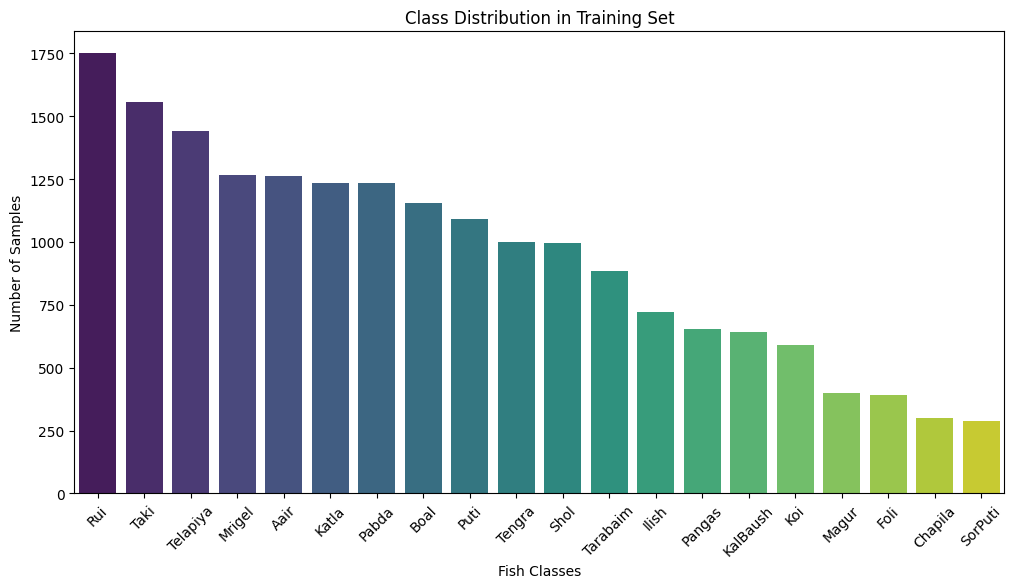

In [7]:
# =======================
# 4. Plot Class Distribution (Training set)
# =======================
labels = []
for c in class_names:
    class_path = os.path.join(train_dir, c)
    imgs = os.listdir(class_path)
    labels.extend([c]*len(imgs))

label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Fish Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()

In [8]:
# =======================
# 5. Directory & Paths Setup (Kaggle paths)
# =======================
base_dir = "/kaggle/working/baseModel"
os.makedirs(base_dir, exist_ok=True)

model_path = os.path.join(base_dir, "baseline_cnn_fish_best.h5")
final_model_path = os.path.join(base_dir, "baseline_cnn_fish_final.h5")
log_path = os.path.join(base_dir, "baseline_cnn_training_log.csv")

# =======================
# 6. Build or Load Model
# =======================
if os.path.exists(model_path):
    print("🔹 Loading previous best model...")
    model = load_model(model_path)
else:
    print("🔹 Building new Baseline CNN model...")
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')   
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

🔹 Building new Baseline CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762972772.222504      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,540 (42.62 MB)

 Trainable params: 11,171,540 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# =======================
# 7. Callbacks
# =======================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
csv_logger = CSVLogger(log_path, append=True)
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)


# =======================
# 8. Train Model
# =======================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, csv_logger, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1762972777.700785     120 service.cc:148] XLA service 0x7fa75c005950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762972777.702050     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762972778.032158     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/590 ━━━━━━━━━━━━━━━━━━━━ 1:12:04 7s/step - accuracy: 0.0938 - loss: 2.9765

I0000 00:00:1762972782.277759     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.1528 - loss: 2.7768
Epoch 1: val_loss improved from inf to 2.30975, saving model to /kaggle/working/baseModel/baseline_cnn_fish_best.h5
590/590 ━━━━━━━━━━━━━━━━━━━━ 369s 614ms/step - accuracy: 0.1529 - loss: 2.7763 - val_accuracy: 0.2942 - val_loss: 2.3097
Epoch 2/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3734 - loss: 1.9021
Epoch 2: val_loss improved from 2.30975 to 1.57316, saving model to /kaggle/working/baseModel/baseline_cnn_fish_best.h5
590/590 ━━━━━━━━━━━━━━━━━━━━ 282s 478ms/step - accuracy: 0.3734 - loss: 1.9019 - val_accuracy: 0.5151 - val_loss: 1.5732
Epoch 3/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4819 - loss: 1.5391
Epoch 3: val_loss improved from 1.57316 to 1.29349, saving model to /kaggle/working/baseModel/baseline_cnn_fish_best.h5
590/590 ━━━━━━━━━━━━━━━━━━━━ 280s 474ms/step - accuracy: 0.4819 - loss: 1.5390 - val_accuracy: 0.5977 - val_loss: 1.2935
Epoch 4/20
590/590 ━━━━━━━━━

In [10]:
# 9. Save Final Model
# =======================
model.save(final_model_path)
print(f" Final model saved to: {final_model_path}")

 Final model saved to: /kaggle/working/baseModel/baseline_cnn_fish_final.h5


In [11]:
# 10. Evaluate on Test Data
# =======================
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\nTesting Accuracy : {test_acc*100:.2f}%")
print(f" Testing Loss     : {test_loss:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 364ms/step - accuracy: 0.9248 - loss: 0.2413

Testing Accuracy : 92.97%
 Testing Loss     : 0.2200


In [12]:
# =======================
# 11. Evaluate on Validation Data
# =======================
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n Validation Accuracy : {val_acc*100:.2f}%")
print(f" Validation Loss     : {val_loss:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.9249 - loss: 0.2243

 Validation Accuracy : 92.92%
 Validation Loss     : 0.2102


In [13]:
# =======================
# . Evaluate on train Data
# =======================
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n train Accuracy : {train_acc*100:.2f}%")
print(f" train Loss     : {train_loss:.4f}")

590/590 ━━━━━━━━━━━━━━━━━━━━ 254s 430ms/step - accuracy: 0.9132 - loss: 0.2734

 train Accuracy : 90.90%
 train Loss     : 0.2811


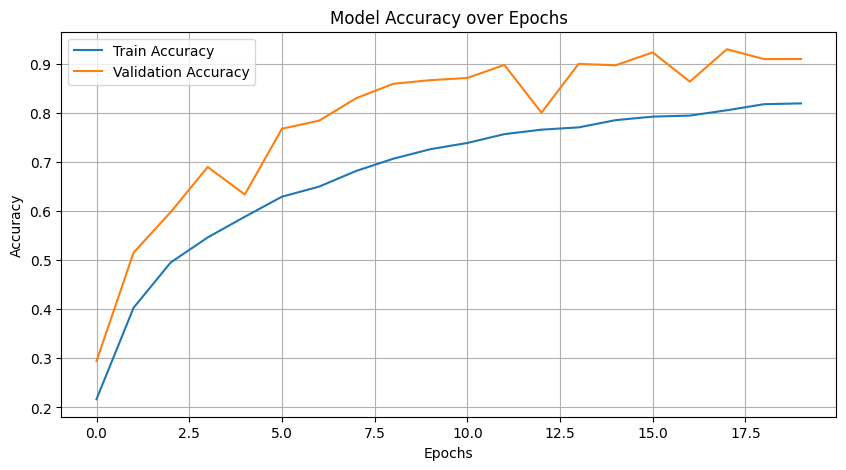

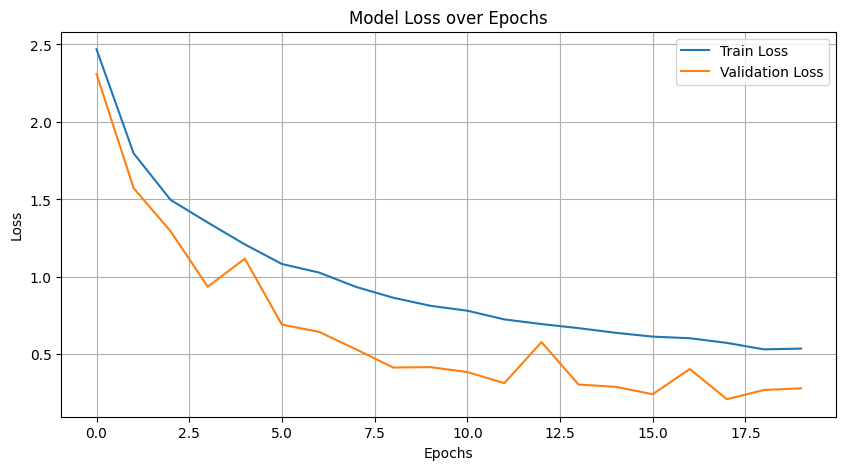

 Training log saved at: /kaggle/working/baseModel/baseline_cnn_training_log.csv


In [14]:
# =======================
# 12. Plot Training History
# =======================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f" Training log saved at: {log_path}")

In [15]:
# =======================
# 13. Predictions
# =======================
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
))

85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step

 Classification Report:

              precision    recall  f1-score   support

        Aair     0.9693    0.8681    0.9159       182
        Boal     0.9625    0.9277    0.9448       166
     Chapila     0.9348    0.9773    0.9556        44
        Foli     0.9123    0.9123    0.9123        57
       Ilish     0.9706    0.9519    0.9612       104
    KalBaush     0.8842    0.9032    0.8936        93
       Katla     0.9448    0.9661    0.9553       177
         Koi     0.8218    0.9765    0.8925        85
       Magur     0.9245    0.8305    0.8750        59
      Mrigel     0.9833    0.9725    0.9779       182
       Pabda     0.9185    0.9494    0.9337       178
      Pangas     0.9792    0.9895    0.9843        95
        Puti     0.8963    0.9423    0.9188       156
         Rui     0.9053    0.9560    0.9300       250
        Shol     0.9038    0.9792    0.9400       144
     SorPuti     1.0000    0.8333    0.9091        42
        Taki 

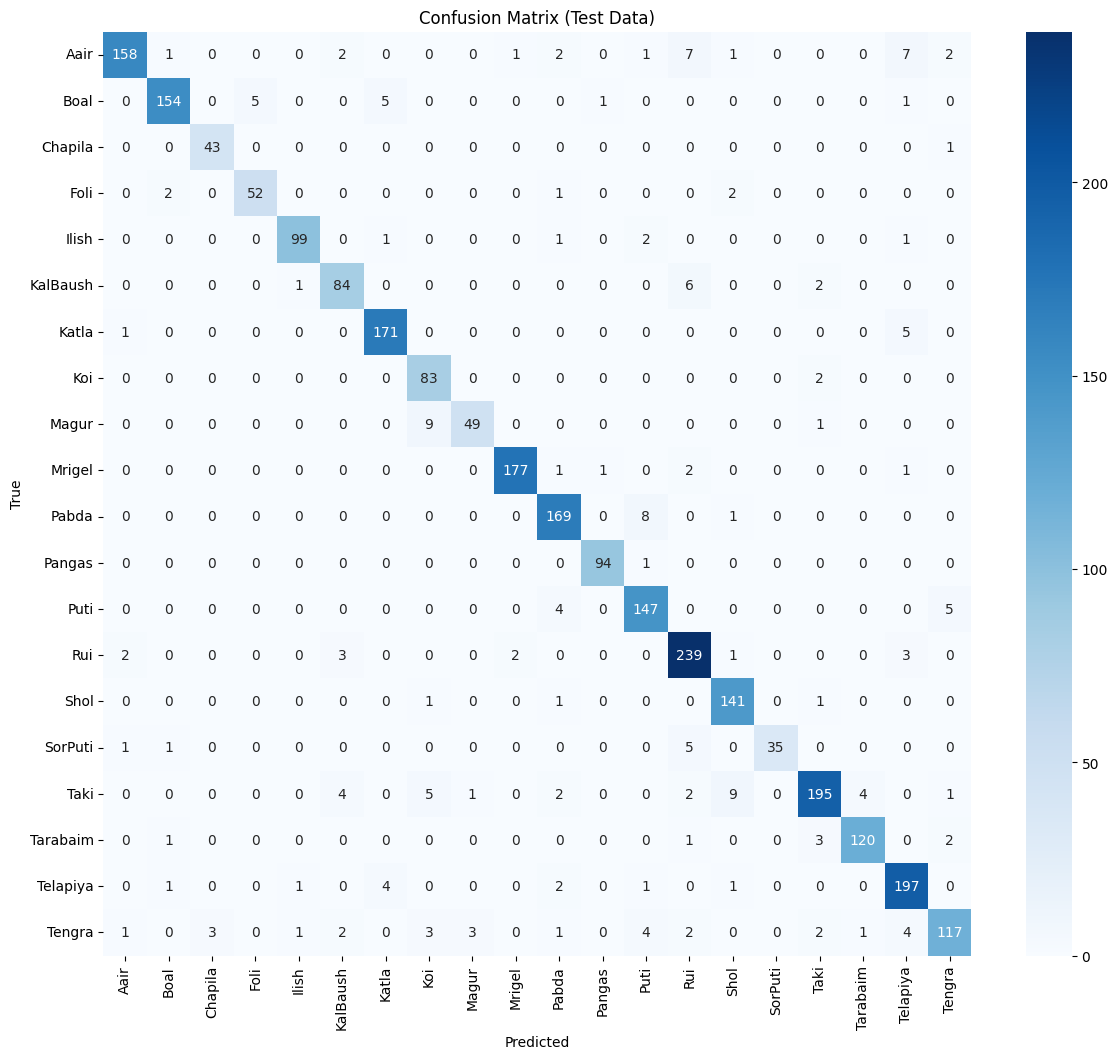

In [16]:
# =======================
# 14. Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Data)")
plt.show()


 Per-Class Metrics:

          Precision  Recall  F1-Score
Class                                
Aair         0.9693  0.8681    0.9159
Boal         0.9625  0.9277    0.9448
Chapila      0.9348  0.9773    0.9556
Foli         0.9123  0.9123    0.9123
Ilish        0.9706  0.9519    0.9612
KalBaush     0.8842  0.9032    0.8936
Katla        0.9448  0.9661    0.9553
Koi          0.8218  0.9765    0.8925
Magur        0.9245  0.8305    0.8750
Mrigel       0.9833  0.9725    0.9779
Pabda        0.9185  0.9494    0.9337
Pangas       0.9792  0.9895    0.9843
Puti         0.8963  0.9423    0.9188
Rui          0.9053  0.9560    0.9300
Shol         0.9038  0.9792    0.9400
SorPuti      1.0000  0.8333    0.9091
Taki         0.9466  0.8744    0.9091
Tarabaim     0.9600  0.9449    0.9524
Telapiya     0.8995  0.9517    0.9249
Tengra       0.9141  0.8125    0.8603


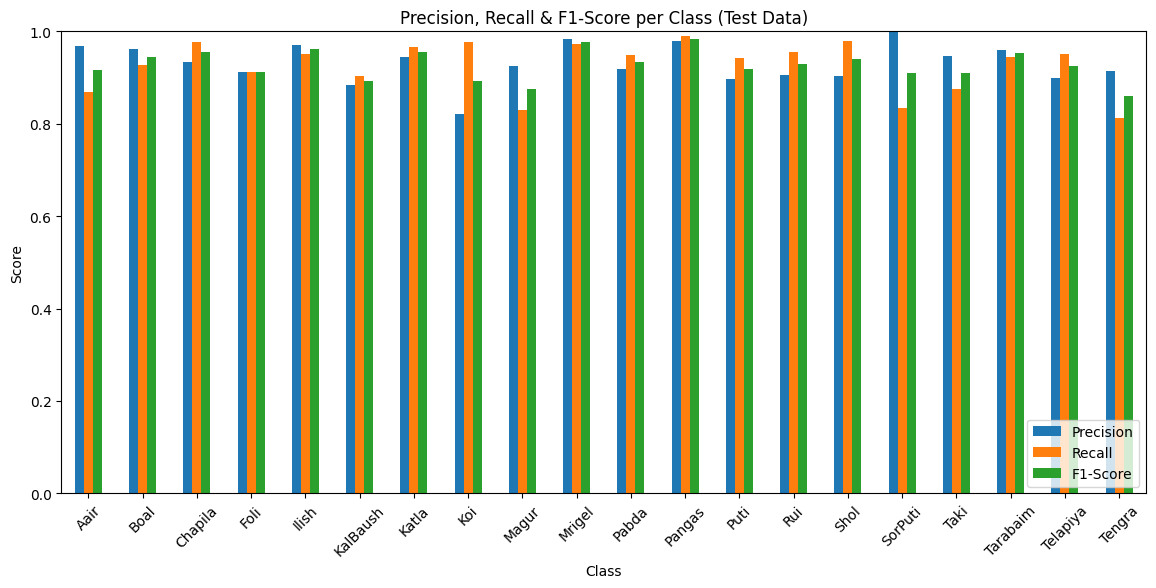

In [17]:
# =======================
# 15. Precision, Recall, F1 per Class
# =======================
precision = precision_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
recall    = recall_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
f1        = f1_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Class')

print("\n Per-Class Metrics:\n")
print(metrics_df.round(4))

metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Precision, Recall & F1-Score per Class (Test Data)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


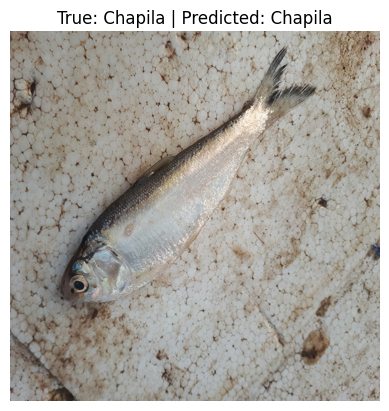

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


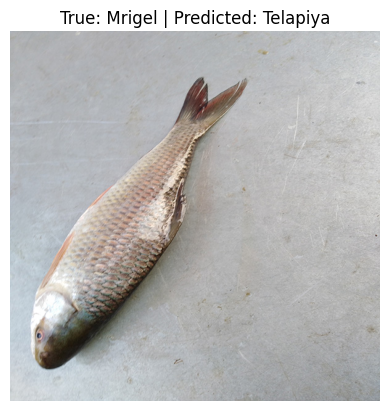

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


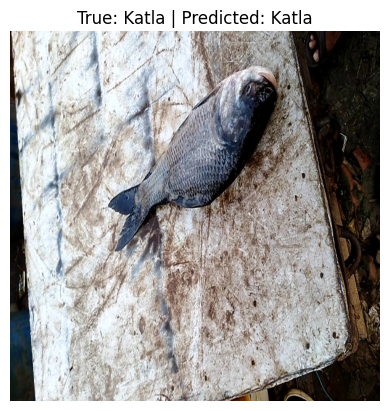

In [18]:
# =======================
# 16. Predict Random Test Images
# =======================
def predict_random_image(test_dir, model, class_names, img_size=(224,224)):
    random_class = random.choice(os.listdir(test_dir))
    class_path = os.path.join(test_dir, random_class)
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    true_class = random_class

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()

# Run 3 random predictions
for i in range(3):
    predict_random_image(test_dir, model, class_names)

In [19]:
# =======================
# 17. Save JSON Summary (For Comparison)
# =======================
import json
import numpy as np
import os


os.makedirs("/kaggle/working/output", exist_ok=True)

results = {
    "dataset": "BangladeshDeltaFish",
    "model": "Baseline CNN",
    "train_acc": float(history.history['accuracy'][-1]),
    "val_acc": float(history.history['val_accuracy'][-1]),
    "test_acc": float(test_acc),
    "precision": float(np.mean(precision)),
    "recall": float(np.mean(recall)),
    "f1": float(np.mean(f1))
}


json_path = "/kaggle/working/output/results_summary.json"

with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

print(f" JSON summary saved successfully at: {json_path}")
print(json.dumps(results, indent=4))

 JSON summary saved successfully at: /kaggle/working/output/results_summary.json
{
    "dataset": "BangladeshDeltaFish",
    "model": "Baseline CNN",
    "train_acc": 0.8189243674278259,
    "val_acc": 0.909310519695282,
    "test_acc": 0.929650068283081,
    "precision": 0.9315712907965328,
    "recall": 0.9259692502915048,
    "f1": 0.927323601175638
}
